exercicio - realizar a clusterização para os dados da IRIS usando  GA+k-means( com codificação real com seleção em torneio, crossover aritmético e mutação gaussiana) 

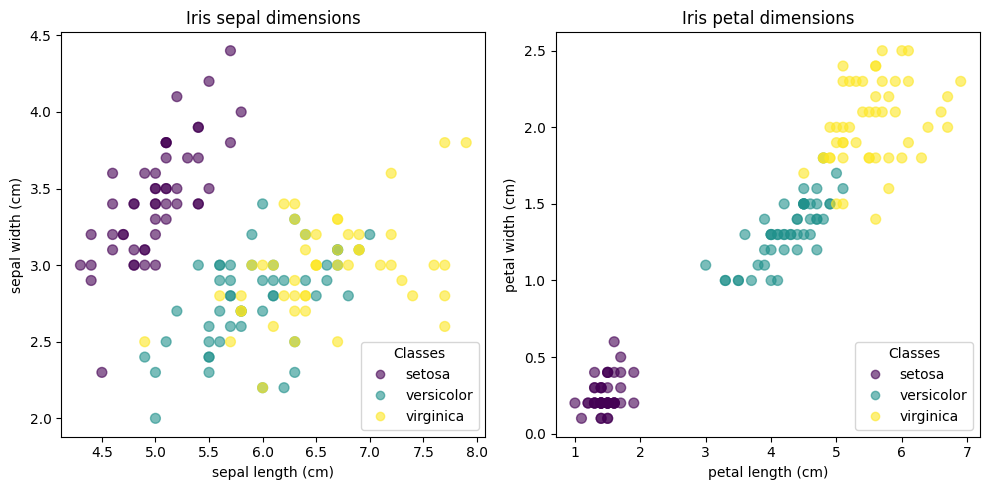

In [1]:
# Load IRIS dataset
from sklearn import datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris() 
X = iris.data
y = iris.target

x_sepallength = X[:,0]
x_sepalwidth = X[:,1]
x_petallength = X[:,2]
x_petalwidth = X[:,3]

# Plotando os dados
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Plot for sepal
scatter_sepal = axs[0].scatter(x_sepallength, x_sepalwidth, c=y, s=50, cmap="viridis", alpha=0.6)
axs[0].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
axs[0].legend(scatter_sepal.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")
axs[0].set_title("Iris sepal dimensions")

# Plot for petal
scatter_petal = axs[1].scatter(x_petallength, x_petalwidth, c=y, s=50, cmap="viridis", alpha=0.6)
axs[1].set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])
axs[1].legend(scatter_petal.legend_elements()[0], iris.target_names, loc="lower right", title="Classes")
axs[1].set_title("Iris petal dimensions")

plt.tight_layout()
plt.show()

In [2]:
import random
import numpy as np
from sklearn.cluster import KMeans


def kmeans_fitness(centroids, X):
    # score is 1 / inertia (the smaller the inertia, the better the score)
    kmeans = KMeans(n_clusters=3, init=centroids, n_init=1, max_iter=1)
    kmeans.fit(X)
    inertia = kmeans.inertia_
    return 1 / inertia


class CentroidWithScore:
    def __init__(self, centroids, score):
        self.centroids = centroids
        self.score = score

    def __repr__(self):
        return f"CentroidWithScore(score={self.score})"

    def __getitem__(self, key):
        return self.centroids[key]


def generate_population(size, X, k=3, feature_size=4):
    population = []
    for _ in range(size):
        centroids = np.array([X[random.randint(0, len(X) - 1)] for _ in range(k)])
        # centroids = np.random.rand(3, 4)  # random centroids
        score = kmeans_fitness(centroids, X)
        population.append(CentroidWithScore(centroids, score))
    return population


def tourney_selection(population: list[CentroidWithScore], k, final_population_size):
    selected = []
    for _ in range(final_population_size):
        tournament = random.sample(population, k)
        winner = max(tournament, key=lambda x: x.score)
        selected.append(winner)
    return selected


def crossover(parent1: CentroidWithScore, parent2: CentroidWithScore, alpha=0.5):
    child_centroids = alpha * parent1.centroids + (1 - alpha) * parent2.centroids
    closest_data_points = np.array(
        [
            X[np.argmin(np.linalg.norm(X - centroid, axis=1))]
            for centroid in child_centroids
        ]
    )
    return CentroidWithScore(
        closest_data_points, kmeans_fitness(closest_data_points, X)
    )


def gaussian_mutation(individual: CentroidWithScore, sigma=0.1):
    mutant = individual.centroids + sigma * np.random.randn(*individual.centroids.shape)
    return CentroidWithScore(mutant, kmeans_fitness(mutant, X))


def next_generation(
    population: list[CentroidWithScore], new_population: list[CentroidWithScore]
):
    population.extend(new_population)
    # sort and choose elite
    population.sort(key=lambda x: x.score, reverse=True)
    new_population = population[: len(population) // 2]
    return new_population


def kmeans_fit(
    population: list[CentroidWithScore],
    iterations=100,
    mutation_rate=0.1,
    crossover_rate=0.5,
):
    history = []
    for _ in range(iterations):
        mating_pool1 = tourney_selection(population, 2, 5)
        mating_pool2 = tourney_selection(population, 2, 5)
        new_population = []
        for _ in range(len(population)):
            parent1 = random.choice(mating_pool1)
            parent2 = random.choice(mating_pool2)
            child = crossover(parent1, parent2, crossover_rate)
            if random.random() < mutation_rate:
                child = gaussian_mutation(child)
            new_population.append(child)
        population = next_generation(population, new_population)
        best_individual = max(population, key=lambda x: x.score)
        history.append(best_individual.score)
    return best_individual, history


initial_population = generate_population(50, X)  # initial centroids
best, history = kmeans_fit(initial_population, iterations=200)
best

CentroidWithScore(score=0.012682076343989507)

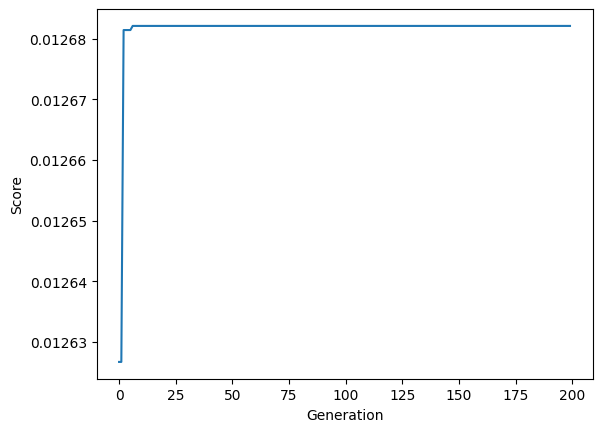

In [3]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.xlabel("Generation")
plt.ylabel("Score")
plt.show()

In [4]:
best.centroids

array([[5.9, 3. , 4.2, 1.5],
       [7.1, 3. , 5.9, 2.1],
       [4.8, 3. , 1.4, 0.3]])

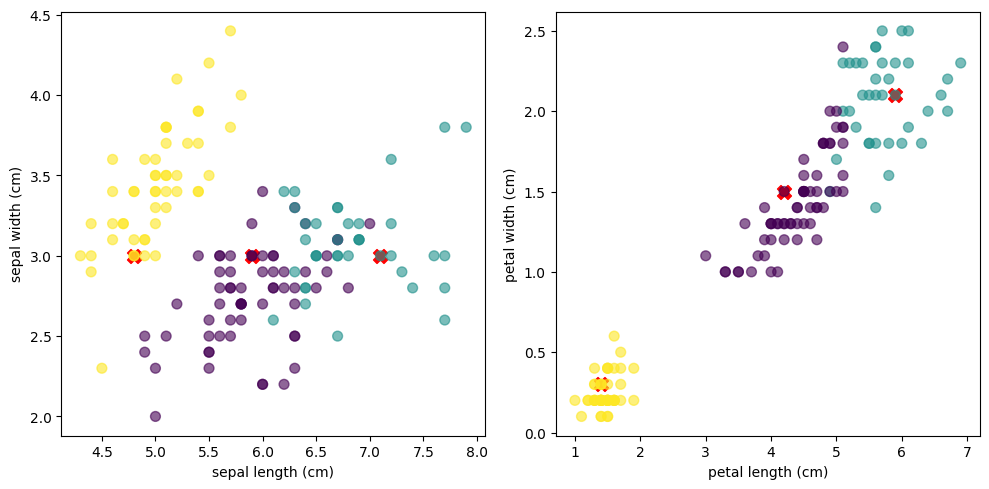

In [11]:
kmeans = KMeans(n_clusters=3, init=best.centroids, n_init=1, max_iter=1)
kmeans.fit(X)

# Plotando os dados
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# plot centroids
axs[0].scatter(best.centroids[:, 0], best.centroids[:, 1], c="red", s=100, alpha=1, marker="X")
axs[1].scatter(best.centroids[:, 2], best.centroids[:, 3], c="red", s=100, alpha=1, marker="X")

# Plot for sepal
scatter_sepal = axs[0].scatter(x_sepallength, x_sepalwidth, c=kmeans.labels_, s=50, cmap="viridis", alpha=0.6)
axs[0].set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])

# Plot for petal
scatter_petal = axs[1].scatter(x_petallength, x_petalwidth, c=kmeans.labels_, s=50, cmap="viridis", alpha=0.6)
axs[1].set(xlabel=iris.feature_names[2], ylabel=iris.feature_names[3])

plt.tight_layout()
plt.show()
